In [1]:
import os, math, saxpy
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats

os.chdir('/home/atom/cvlab/thesis/')
print(os.getcwd())

/home/atom/cvlab/thesis


# Normalization

It is standard practice in tasks where skeletal data is used (ex. Action Recognition etc.) to scale the skeleton joints
so that their 3D coordinates are in the interval of [-1, 1][1] and transform the joints to be relative to a root joint, which
in most cases is the hip [2].

In [2]:
from dataset.dataset import JumpPoseDataset

pose_paths = './dataset/marker_data'
info_path = './dataset/info.xlsx'
dataset = JumpPoseDataset(pose_paths, info_path, mode='3D')
poses, labels = zip(*dataset)
X = poses[0]
X.shape

(1137, 29, 3)

## Step 1. Relativize to center joint

In [3]:
def make_relative(X, joint_idx):
    return X - X [:, joint_idx,np.newaxis, :]

print('\nBefore:\n', X.mean(axis=(0, 2)))
relative_X = make_relative(X, 15)
print('\nAfter:\n', relative_X.mean(axis=(0, 2)))


Before:
 [0.63281599 0.11516744 0.2331449  0.3373785  0.61023754 0.39844153
 0.25379131 0.12266565 0.39208264 0.26480485 0.29406265 0.16684888
 0.17528554 0.16345268 0.12397718 0.18749092 0.17430963 0.14018862
 0.11177346 0.19378158 0.48979085 0.42876669 0.54561129 0.68071972
 0.14385727 0.51728983 0.25422417 0.16476784 0.54760733]

After:
 [ 0.44532507 -0.07232348  0.04565398  0.14988757  0.42274662  0.21095061
  0.06630038 -0.06482527  0.20459171  0.07731393  0.10657173 -0.02064204
 -0.01220538 -0.02403824 -0.06351374  0.         -0.0131813  -0.0473023
 -0.07571746  0.00629066  0.30229993  0.24127576  0.35812037  0.4932288
 -0.04363365  0.32979891  0.06673325 -0.02272308  0.36011641]


## Step 2. Normalize range to -1, 1

In [4]:
def normalize(X, mn, mx):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (mx - mn) + mn
    
    return X_scaled

print('\nBefore:\n', relative_X.min(), relative_X.max())
normalized_X = normalize(relative_X, -1, 1)
print('\nAfter:\n', normalized_X.min(), normalized_X.max())


Before:
 -0.41802900000000004 1.5070729999999999

After:
 -1.0 1.0


## Step 3. Visualize

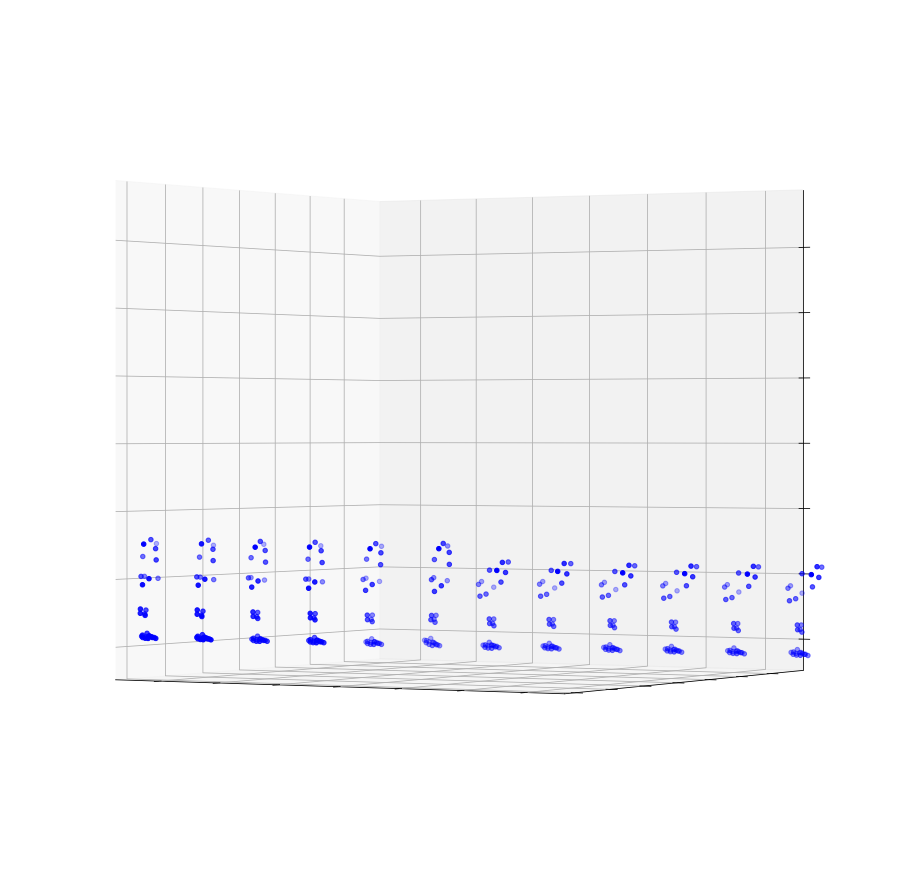

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_sequence(x, step, color='blue'):
    X, Z, Y = x[:, :, 0].T, x[:, :, 1].T, x[:, :, 2].T
    max_range = np.array([X.max()+1000//step-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 3.0
    mid_x = (X.max()+len(x)//step+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(projection='3d')

    for i in range(0, len(x), step):

        fig.patch.set_alpha(0.)
        ax.patch.set_alpha(0.)
        
        xs, zs, ys = x[i].T
        ax.scatter(xs+i/step, ys, zs-max_range*0.7, c=color)
        
    ax.view_init(0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

show_sequence(normalized_X, 100)

## Success/Fail comparison

In [9]:
for idx in range(10):
    X = poses[idx]
    y = np.asarray([label[0] for label in labels])[idx]
    
    print(f'The label of poses[{idx}] is {y}')

The label of poses[0] is 1.0
The label of poses[1] is 1.0
The label of poses[2] is 1.0
The label of poses[3] is 0.0
The label of poses[4] is 1.0
The label of poses[5] is 1.0
The label of poses[6] is 1.0
The label of poses[7] is 0.0
The label of poses[8] is 1.0
The label of poses[9] is 1.0


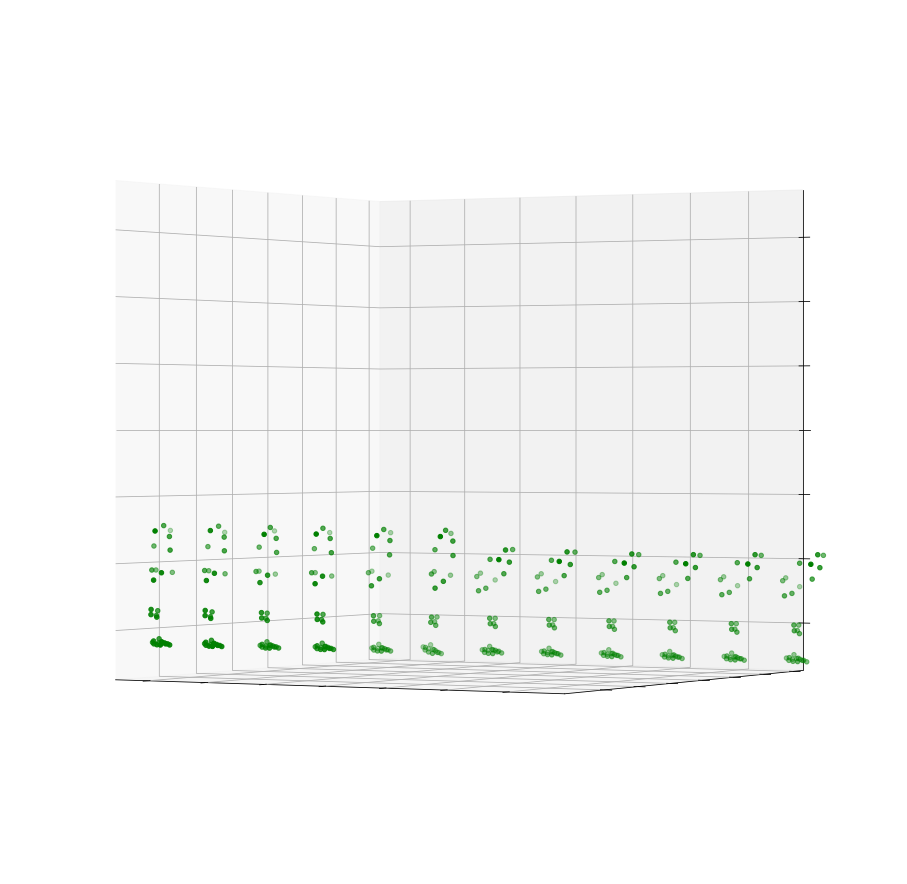

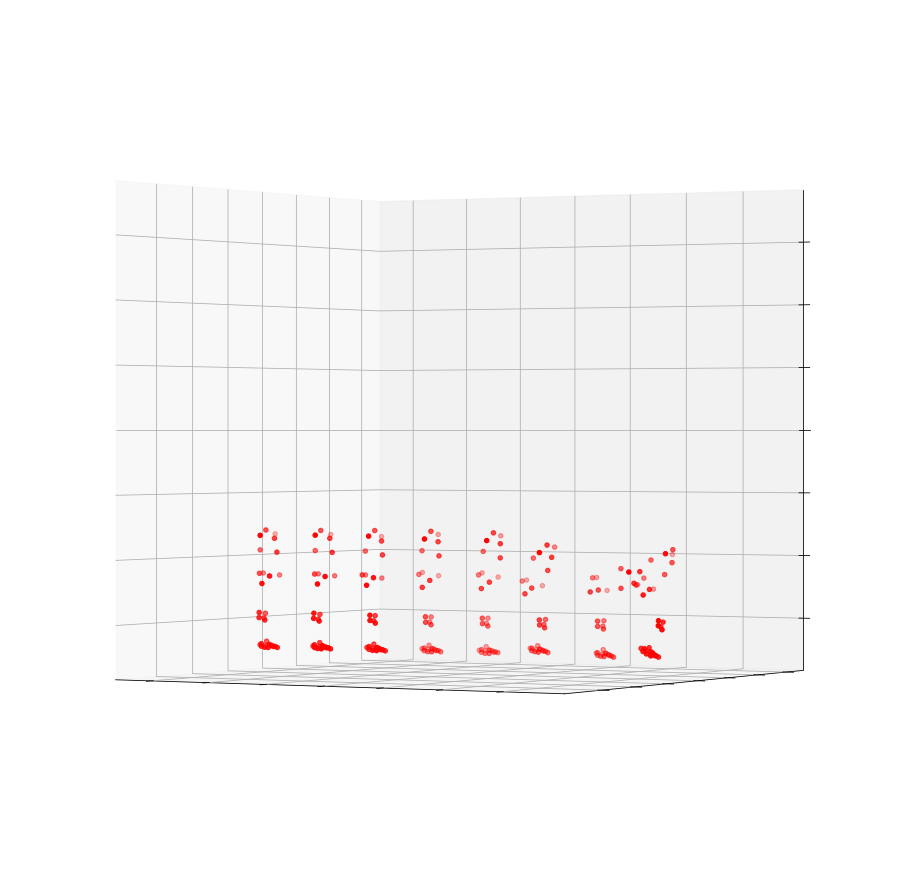

In [10]:
succ_X = poses[0]
fail_X = poses[3]

show_sequence(normalize(make_relative(succ_X, 10), -1, 1), 100, color='green')
show_sequence(normalize(make_relative(fail_X, 10), -1, 1), 100, color='red')